In [1]:
!pip install pydicom pywavelets scikit-image numpy matplotlib

In [2]:
!ls -l /kaggle/input/uc-berkeley-mri-dataset-case1/P1/p1/e1/s1/
!ls -l /kaggle/input/uc-berkeley-mri-dataset-case1/P1_dcm/P1_dcm/Sec_128.mag

total 1638488
-rw-r--r-- 1 nobody nogroup      79784 Jun  2 09:54 GEheader.txt
-rw-r--r-- 1 nobody nogroup 1677721600 Jun  2 09:55 kspace.cfl
-rw-r--r-- 1 nobody nogroup         30 Jun  2 09:54 kspace.hdr
-rw-r--r-- 1 nobody nogroup        595 Jun  2 09:54 params.txt
-rw-r--r-- 1 nobody nogroup 531552 Jun  2 09:54 /kaggle/input/uc-berkeley-mri-dataset-case1/P1_dcm/P1_dcm/Sec_128.mag


DICOM directory: /kaggle/input/uc-berkeley-mri-dataset-case1/P1_dcm/P1_dcm/
K-space file: /kaggle/input/uc-berkeley-mri-dataset-case1/P1/p1/e1/s1/kspace.cfl
Params file: /kaggle/input/uc-berkeley-mri-dataset-case1/P1/p1/e1/s1/params.txt
Selected DICOM file: /kaggle/input/uc-berkeley-mri-dataset-case1/P1_dcm/P1_dcm/Sec_128.mag
Contents of params.txt:
['This is a short summary of the GE header file output\n', '...PSD name from inside PSD: 3DFSE\n', '...Magnet strength (in Gauss): 30000\n', '    The clinicalCoilName of the active coil: C-GE_HDx TR Knee PA\n', '...rhnframes yres: 320\n', '...rhfrsize xres: 320\n', '...rhnslices slices in a pass: 256\n', '...Display field of view - x (mm): 160\n', '...Display field of view - y (if different): 160\n', '...Variable bandwidth (kHz): 50\n', '...Pulse repetition time (usec): 1550000\n', '...Pulse echo time (usec): 25661\n', '...Echo train length for fast spin echo: 40\n', '...Slice thickness (mm): 0.6\n', '...Spacing between scans (mm): 0\n', '.

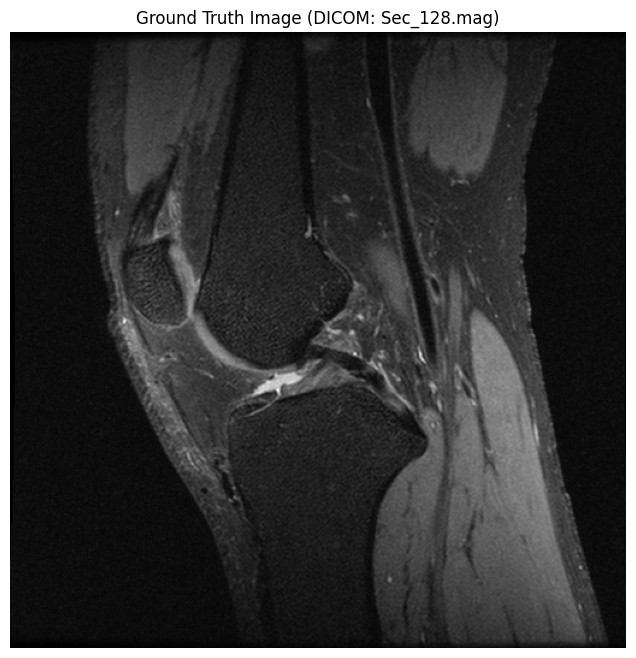

Slice 126 (offset -2): PSNR=11.82 dB
Slice 127 (offset -1): PSNR=12.14 dB
Slice 128 (offset 0): PSNR=15.67 dB
Slice 129 (offset 1): PSNR=16.38 dB
Slice 130 (offset 2): PSNR=15.96 dB

--- Starting CS Simulation ---

Testing Cartesian Mask (R=4)
Starting ISTA: iterations=10, lambda=0.0001, wavelet=db4, level=3
ISTA Iteration 1/10, Current PSNR: 32.4069 dB
ISTA Iteration 2/10, Current PSNR: 32.6054 dB
ISTA Iteration 3/10, Current PSNR: 32.6606 dB
ISTA Iteration 4/10, Current PSNR: 32.6767 dB
ISTA Iteration 5/10, Current PSNR: 32.6819 dB
ISTA Iteration 6/10, Current PSNR: 32.6837 dB
ISTA Iteration 7/10, Current PSNR: 32.6845 dB
ISTA Iteration 8/10, Current PSNR: 32.6848 dB
ISTA Iteration 9/10, Current PSNR: 32.6849 dB
ISTA Iteration 10/10, Current PSNR: 32.6850 dB
Cartesian Mask: ZF PSNR=31.700, ISTA PSNR=32.685, ZF SSIM=0.8244, ISTA SSIM=0.8356, Time=0.47s

Testing Random 2D Mask (R=4)
Starting ISTA: iterations=10, lambda=0.0001, wavelet=db4, level=3
ISTA Iteration 1/10, Current PSNR: 30.

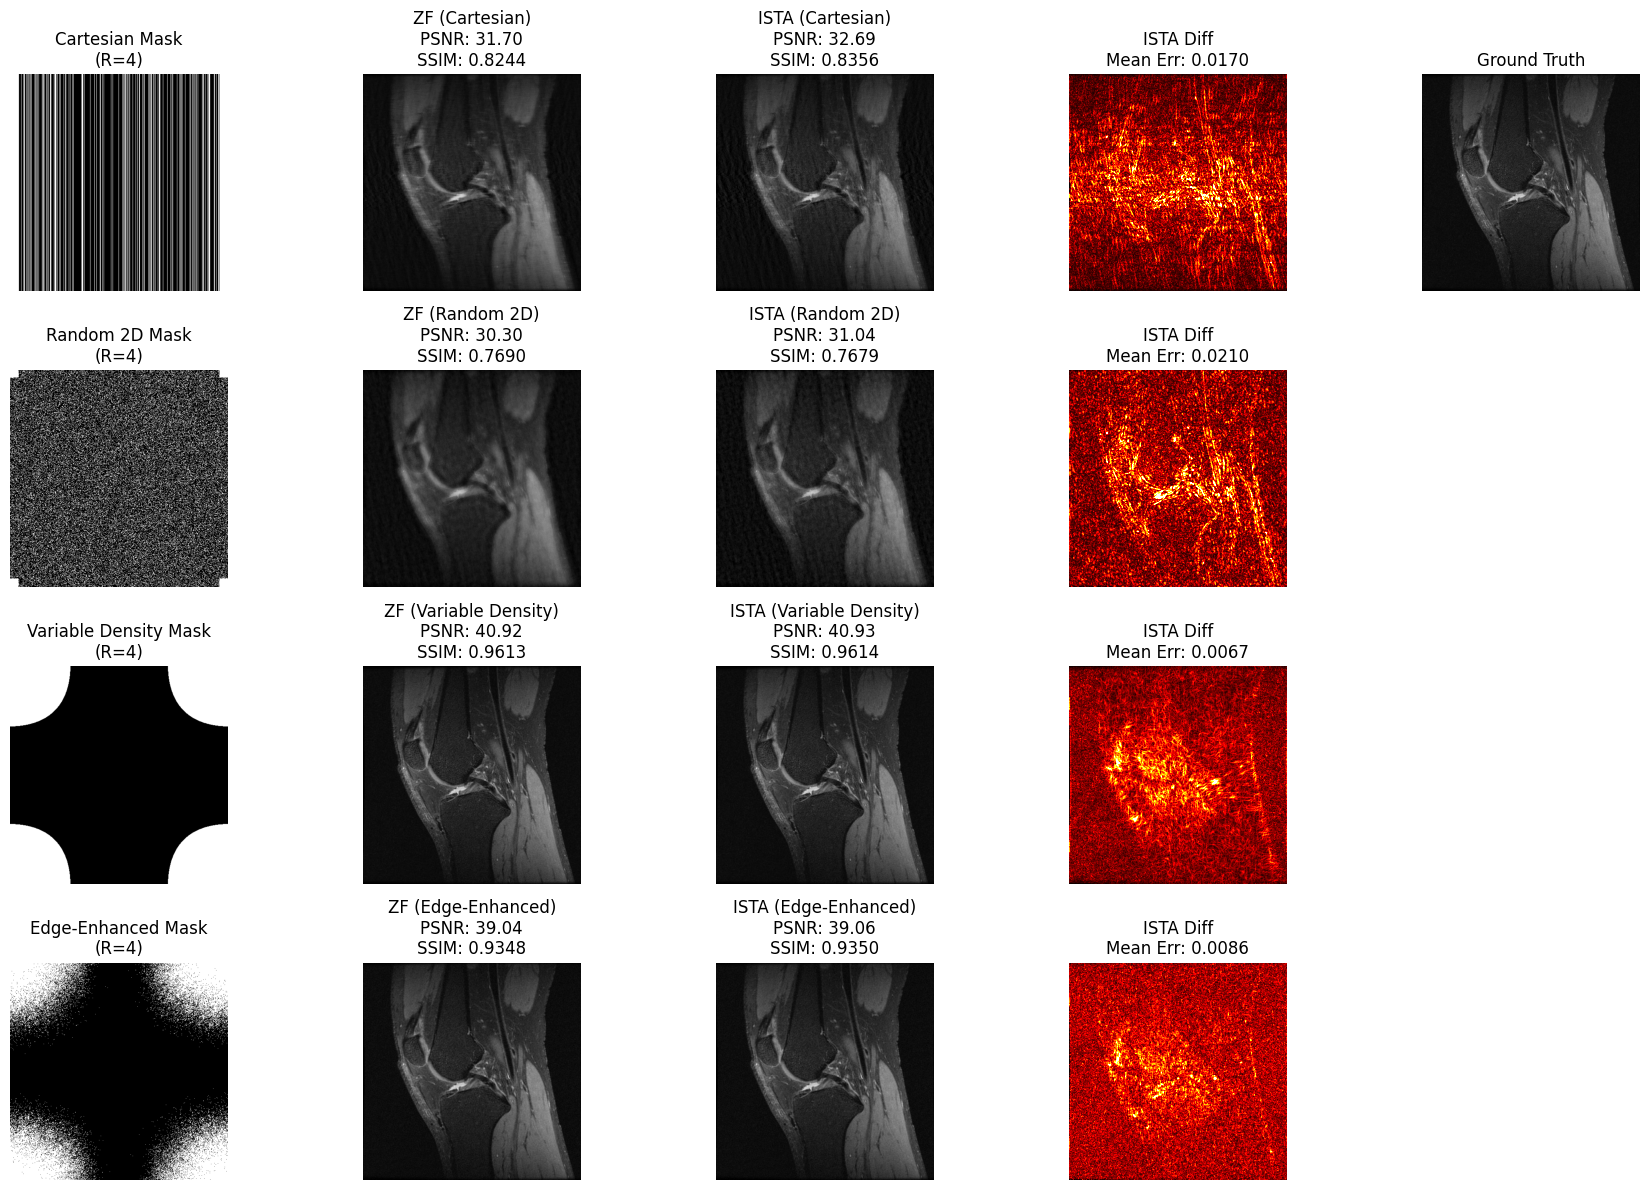


--- Summary of Results (R=4) ---
DICOM File                     | Mask            | ZF PSNR    | ISTA PSNR  | ZF SSIM    | ISTA SSIM  | Time (s)  
----------------------------------------------------------------------------------------------------
Sec_128.mag                    | Cartesian       | 31.700     | 32.685     | 0.8244     | 0.8356     | 0.47      
Sec_128.mag                    | Random 2D       | 30.304     | 31.039     | 0.7690     | 0.7679     | 0.51      
Sec_128.mag                    | Variable Density | 40.916     | 40.929     | 0.9613     | 0.9614     | 0.47      
Sec_128.mag                    | Edge-Enhanced   | 39.038     | 39.061     | 0.9348     | 0.9350     | 0.56      

--- Comparison to Reference Paper ---
Paper's Edge-Enhanced (R=4, 25% data): PSNR=33.52 dB, SSIM=0.4206 (TV algorithm)
Paper's Edge-Enhanced (R=2, 50% data): PSNR=34.76 dB, SSIM=0.4008 (TV algorithm)
Your Best (Variable Density, R=4, 25% data, Sec_128.mag): PSNR=40.93 dB, SSIM=0.9614 (ISTA)



In [3]:
import os
import numpy as np
import matplotlib.pyplot as plt
import pywt
from numpy.fft import fft2, ifft2, fftshift, ifftshift
from skimage.metrics import peak_signal_noise_ratio as psnr
from skimage.metrics import structural_similarity as ssim
from skimage.filters import sobel
import time
import pydicom
import glob
import re

# --- 1. DEFINE BASE PATHS ---
base_kaggle_input_path = '/kaggle/input/'
dataset_name = 'uc-berkeley-mri-dataset-case1'
dicom_dir = os.path.join(base_kaggle_input_path, dataset_name, 'P1_dcm/P1_dcm/')
kspace_cfl_path = os.path.join(base_kaggle_input_path, dataset_name, 'P1/p1/e1/s1/kspace.cfl')
params_path = os.path.join(base_kaggle_input_path, dataset_name, 'P1/p1/e1/s1/params.txt')
print(f"DICOM directory: {dicom_dir}")
print(f"K-space file: {kspace_cfl_path}")
print(f"Params file: {params_path}")

# --- 2. LOAD DICOM FILES ---
dicom_files = [os.path.join(dicom_dir, 'Sec_128.mag')]  # Focus on Sec_128.mag
print(f"Selected DICOM file: {dicom_files[0]}")
if not os.path.exists(dicom_files[0]):
    print(f"ERROR: {dicom_files[0]} not found")
    exit()

# --- 3. LOAD K-SPACE DATA ---
def read_params_dims(params_path):
    """
    Read matrix size, coils, and slices from params.txt.
    Returns (rows, cols, coils, slices) or None if not found.
    """
    if not os.path.exists(params_path):
        print(f"WARNING: params.txt not found at {params_path}")
        return None
    try:
        with open(params_path, 'r') as f:
            lines = f.readlines()
            print(f"Contents of params.txt:\n{lines}")
            rows, cols, coils, slices = None, None, 8, None  # Assume 8 coils
            for line in lines:
                line = line.strip().lower()
                if 'rhnframes yres' in line:
                    nums = [int(x) for x in re.findall(r'\d+', line)]
                    if nums:
                        rows = nums[0]
                if 'rhfrsize xres' in line:
                    nums = [int(x) for x in re.findall(r'\d+', line)]
                    if nums:
                        cols = nums[0]
                if 'rhnslices' in line:
                    nums = [int(x) for x in re.findall(r'\d+', line)]
                    if nums:
                        slices = nums[0]
                if 'coils' in line or 'channels' in line:
                    nums = [int(x) for x in re.findall(r'\d+', line)]
                    if nums:
                        coils = nums[0]
            if rows and cols and slices:
                return rows, cols, coils, slices
        print("No matrix size or slices found in params.txt")
        return None
    except Exception as e:
        print(f"ERROR reading params.txt: {e}")
        return None

def zero_pad_kspace(kspace, target_shape=(512, 512)):
    """
    Zero-pad k-space to target shape, centering the original data.
    """
    rows, cols = kspace.shape[:2]
    target_rows, target_cols = target_shape
    pad_rows_top = (target_rows - rows) // 2
    pad_rows_bottom = target_rows - rows - pad_rows_top
    pad_cols_left = (target_cols - cols) // 2
    pad_cols_right = target_cols - cols - pad_cols_left
    kspace_padded = np.pad(kspace, ((pad_rows_top, pad_rows_bottom), (pad_cols_left, pad_cols_right)),
                           mode='constant', constant_values=0)
    return kspace_padded

def read_cfl_data(cfl_path, dims):
    """
    Read k-space data from .cfl file using specified dimensions (rows, cols, coils, slices).
    Assumes interleaved real/imaginary parts.
    """
    if not os.path.exists(cfl_path):
        print(f"WARNING: CFL file not found at {cfl_path}")
        return None
    try:
        data = np.fromfile(cfl_path, dtype=np.float32)
        expected_size = 2 * np.prod(dims)  # 2 for real/imaginary
        if data.size != expected_size:
            raise ValueError(f"CFL file size mismatch for dimensions {dims}. Expected {expected_size} values, got {data.size}")
        complex_data = data[::2] + 1j * data[1::2]
        kspace_data = complex_data.reshape(dims, order='F')
        return kspace_data
    except Exception as e:
        print(f"ERROR reading .cfl file: {e}")
        return None

# Get dimensions from params.txt or use defaults
params_dims = read_params_dims(params_path)
if params_dims is None:
    print(f"Using default k-space dimensions: 320x320, 8 coils, 256 slices")
    dims = (320, 320, 8, 256)
else:
    rows, cols, coils, slices = params_dims
    dims = (rows, cols, coils, slices)
    print(f"Using dimensions from params.txt: rows={rows}, cols={cols}, coils={coils}, slices={slices}")

# Load k-space data
kspace_data = read_cfl_data(kspace_cfl_path, dims)
use_dicom_kspace = False
if kspace_data is None:
    print(f"WARNING: Failed to load k-space data. Using DICOM-based k-space.")
    use_dicom_kspace = True

# --- 4. PROCESS DICOM FILE ---
all_results = []
for dicom_idx, dicom_path in enumerate(dicom_files):
    print(f"\nProcessing DICOM file ({dicom_idx+1}/{len(dicom_files)}): {dicom_path}")
    try:
        # Load DICOM
        dicom_data = pydicom.dcmread(dicom_path)
        ground_truth_image = dicom_data.pixel_array.astype(np.float32)
        if ground_truth_image.shape != (512, 512):
            print(f"ERROR: Unexpected shape {ground_truth_image.shape}")
            continue
        print(f"Loaded DICOM image with shape: {ground_truth_image.shape}, dtype: {ground_truth_image.dtype}")

        # Normalize ground truth image to [0, 1]
        if np.max(ground_truth_image) > np.min(ground_truth_image):
            ground_truth_image = (ground_truth_image - np.min(ground_truth_image)) / \
                                 (np.max(ground_truth_image) - np.min(ground_truth_image))
        else:
            ground_truth_image = np.zeros_like(ground_truth_image)
        print(f"Normalized ground truth image shape: {ground_truth_image.shape}, "
              f"range: [{np.min(ground_truth_image):.2f}, {np.max(ground_truth_image):.2f}]")

        # Display ground truth image
        plt.figure(figsize=(8, 8))
        plt.imshow(ground_truth_image, cmap='gray')
        plt.title(f"Ground Truth Image (DICOM: {os.path.basename(dicom_path)})")
        plt.axis('off')
        plt.show()

        # Get k-space for slice 128
        slice_idx = 128
        if not use_dicom_kspace and kspace_data is not None:
            if slice_idx >= dims[3]:
                print(f"WARNING: Slice index {slice_idx} exceeds k-space slices {dims[3]}. Using DICOM-based k-space.")
                kspace_2d = fftshift(fft2(ground_truth_image))
                use_dicom_kspace = True
            else:
                # Try multiple slice offsets
                best_psnr = -np.inf
                best_kspace_2d = None
                for offset in [-2, -1, 0, 1, 2]:
                    test_idx = slice_idx + offset
                    if 0 <= test_idx < dims[3]:
                        kspace_slice = kspace_data[:, :, :, test_idx]  # Shape: (320, 320, 8)
                        image_slice = ifft2(ifftshift(kspace_slice, axes=(0, 1)), axes=(0, 1))  # Shape: (320, 320, 8)
                        image_rss = np.sqrt(np.sum(np.abs(image_slice)**2, axis=2))  # Shape: (320, 320)
                        kspace_test = zero_pad_kspace(fftshift(fft2(image_rss), axes=(0, 1)))
                        kspace_recon = np.abs(ifft2(ifftshift(kspace_test)))
                        if np.max(kspace_recon) > np.min(kspace_recon):
                            kspace_recon = (kspace_recon - np.min(kspace_recon)) / \
                                           (np.max(kspace_recon) - np.min(kspace_recon))
                        test_psnr = psnr(ground_truth_image, kspace_recon, data_range=1.0)
                        print(f"Slice {test_idx} (offset {offset}): PSNR={test_psnr:.2f} dB")
                        if test_psnr > best_psnr:
                            best_psnr = test_psnr
                            best_kspace_2d = kspace_test
                if best_psnr > 20:
                    kspace_2d = best_kspace_2d
                    print(f"Selected k-space for slice {slice_idx} (best PSNR={best_psnr:.2f} dB), shape: {kspace_2d.shape}")
                else:
                    print(f"WARNING: Best k-space PSNR ({best_psnr:.2f} dB) too low. Using DICOM-based k-space.")
                    kspace_2d = fftshift(fft2(ground_truth_image))
                    use_dicom_kspace = True
        else:
            print(f"Using DICOM-based k-space for slice {slice_idx}.")
            kspace_2d = fftshift(fft2(ground_truth_image))

        # --- 5. CS SIMULATION ---
        print("\n--- Starting CS Simulation ---")
        k_space_full = kspace_2d

        # Define mask creation functions
        def create_cartesian_mask(shape, acceleration_factor, center_fraction=0.08):
            num_cols = shape[1]
            num_low_freqs = int(round(num_cols * center_fraction))
            mask = np.zeros(shape, dtype=bool)
            pad = (num_cols - num_low_freqs + 1) // 2
            mask[:, pad:pad + num_low_freqs] = True
            num_sampled_lines_outer = (num_cols - num_low_freqs) // acceleration_factor
            outer_lines_indices = np.setdiff1d(np.arange(num_cols), np.arange(pad, pad + num_low_freqs))
            permuted_outer_lines = np.random.permutation(outer_lines_indices)
            selected_outer_lines = permuted_outer_lines[:num_sampled_lines_outer]
            mask[:, selected_outer_lines] = True
            return mask

        def create_random_2d_mask(shape, acceleration_factor, center_fraction=0.08, seed=None):
            if seed is not None:
                np.random.seed(seed)
            num_points = int(np.prod(shape) / acceleration_factor)
            mask = np.zeros(shape, dtype=bool)
            center_rows = int(shape[0] * center_fraction)
            center_cols = int(shape[1] * center_fraction)
            r_start, r_end = shape[0]//2 - center_rows//2, shape[0]//2 + center_rows//2
            c_start, c_end = shape[1]//2 - center_cols//2, shape[1]//2 + center_cols//2
            mask[r_start:r_end, c_start:c_end] = True
            num_sampled_center = np.sum(mask)
            remaining_points = num_points - num_sampled_center
            if remaining_points > 0:
                outer_indices = [(r, c) for r in range(shape[0]) for c in range(shape[1])
                                 if not (r_start <= r < r_end and c_start <= c < c_end)]
                if len(outer_indices) > 0:
                    chosen_indices = np.random.choice(len(outer_indices), 
                                                     max(0, min(remaining_points, len(outer_indices))), 
                                                     replace=False)
                    for idx in chosen_indices:
                        r, c = outer_indices[idx]
                        mask[r, c] = True
            return mask

        def create_variable_density_mask(shape, acceleration_factor, center_fraction=0.08, poly_degree=2, seed=None):
            if seed is not None:
                np.random.seed(seed)
            rows, cols = shape
            center_x, center_y = cols // 2, rows // 2
            x_coords = np.abs(np.arange(cols) - center_x)
            y_coords = np.abs(np.arange(rows) - center_y)
            dist_x, dist_y = np.meshgrid(x_coords, y_coords)
            norm_dist_x = dist_x / (np.max(dist_x) if np.max(dist_x) > 0 else 1)
            norm_dist_y = dist_y / (np.max(dist_y) if np.max(dist_y) > 0 else 1)
            pdf = (1 - norm_dist_x**poly_degree) * (1 - norm_dist_y**poly_degree)
            pdf = np.clip(pdf, 0, 1)
            target_samples = int(np.prod(shape) / acceleration_factor)
            flat_pdf = pdf.flatten()
            sorted_indices = np.argsort(-flat_pdf)
            mask = np.zeros(shape, dtype=bool).flatten()
            mask[sorted_indices[:target_samples]] = True
            mask = mask.reshape(shape)
            center_rows_abs = int(shape[0] * center_fraction)
            center_cols_abs = int(shape[1] * center_fraction)
            r_start, r_end = shape[0]//2 - center_rows_abs//2, shape[0]//2 + center_rows_abs//2
            c_start, c_end = shape[1]//2 - center_cols_abs//2, shape[1]//2 + center_cols_abs//2
            mask[r_start:r_end, c_start:c_end] = True
            actual_accel = np.prod(shape) / np.sum(mask)
            print(f"  Variable Density Mask: Target R={acceleration_factor}, Actual R={actual_accel:.2f}")
            return mask

        def create_edge_enhanced_mask(shape, acceleration_factor, reference_image, center_fraction=0.08, seed=None):
            if seed is not None:
                np.random.seed(seed)
            edge_map = sobel(reference_image)
            edge_map = np.clip(edge_map, 0, np.percentile(edge_map, 99))
            if np.max(edge_map) > np.min(edge_map):
                edge_map = (edge_map - np.min(edge_map)) / (np.max(edge_map) - np.min(edge_map))
            k_space_edge = fftshift(fft2(edge_map))
            k_space_energy = np.abs(k_space_edge)
            k_space_energy = np.clip(k_space_energy, 0, np.percentile(k_space_energy, 99))
            if np.max(k_space_energy) > np.min(k_space_energy):
                k_space_energy = (k_space_energy - np.min(k_space_energy)) / \
                                 (np.max(k_space_energy) - np.min(k_space_energy))
            rows, cols = shape
            center_x, center_y = cols // 2, rows // 2
            x_coords = np.abs(np.arange(cols) - center_x) / (cols / 2)
            y_coords = np.abs(np.arange(rows) - center_y) / (rows / 2)
            dist_x, dist_y = np.meshgrid(x_coords, y_coords)
            center_pdf = (1 - dist_x**2) * (1 - dist_y**2)
            center_pdf = np.clip(center_pdf, 0, 1)
            edge_weight = 0.7
            pdf = edge_weight * k_space_energy + (1 - edge_weight) * center_pdf
            pdf = np.clip(pdf, 0, 1)
            target_samples = int(np.prod(shape) / acceleration_factor)
            flat_pdf = pdf.flatten()
            sorted_indices = np.argsort(-flat_pdf)
            mask = np.zeros(shape, dtype=bool).flatten()
            mask[sorted_indices[:target_samples]] = True
            mask = mask.reshape(shape)
            center_rows_abs = int(shape[0] * center_fraction)
            center_cols_abs = int(shape[1] * center_fraction)
            r_start, r_end = shape[0]//2 - center_rows_abs//2, shape[0]//2 + center_rows_abs//2
            c_start, c_end = shape[1]//2 - center_cols_abs//2, shape[1]//2 + center_cols_abs//2
            mask[r_start:r_end, c_start:c_end] = True
            actual_accel = np.prod(shape) / np.sum(mask)
            print(f"  Edge-Enhanced Mask: Target R={acceleration_factor}, Actual R={actual_accel:.2f}")
            return mask

        # ISTA reconstruction function
        def soft_threshold(x, threshold):
            return np.sign(x) * np.maximum(np.abs(x) - threshold, 0)

        def wavelet_forward(image, wavelet='db4', level=3):
            coeffs = pywt.wavedec2(image, wavelet=wavelet, level=level)
            arr, coeff_slices = pywt.coeffs_to_array(coeffs)
            return arr, coeff_slices

        def wavelet_inverse(arr, coeff_slices, wavelet='db4'):
            coeffs_from_arr = pywt.array_to_coeffs(arr, coeff_slices, output_format='wavedec2')
            return pywt.waverec2(coeffs_from_arr, wavelet=wavelet)

        def ista_wavelet_cs(k_space_undersampled, mask, initial_image, n_iters, lambda_val,
                            ground_truth_for_psnr, wavelet='db4', level=3):
            x_recon = initial_image.copy().astype(np.complex128)
            k_space_undersampled = k_space_undersampled.astype(np.complex128)
            step_size = 1.0

            print(f"Starting ISTA: iterations={n_iters}, lambda={lambda_val}, wavelet={wavelet}, level={level}")

            for i in range(n_iters):
                current_k_space = fftshift(fft2(x_recon))
                k_space_error = (current_k_space * mask) - k_space_undersampled
                grad_data_term = ifft2(ifftshift(k_space_error * mask))
                x_intermediate = x_recon - step_size * grad_data_term
                x_intermediate_real = np.real(x_intermediate)
                
                coeffs_arr, coeff_slices = wavelet_forward(x_intermediate_real, wavelet=wavelet, level=level)
                threshold = lambda_val * step_size
                coeffs_list_form = pywt.wavedec2(x_intermediate_real, wavelet=wavelet, level=level)
                approx_coeffs_size = coeffs_list_form[0].size
                coeffs_arr_thresh = coeffs_arr.copy()
                coeffs_arr_thresh[approx_coeffs_size:] = soft_threshold(coeffs_arr[approx_coeffs_size:], threshold)
                x_reconstructed_real = wavelet_inverse(coeffs_arr_thresh, coeff_slices, wavelet=wavelet)
                x_recon = x_reconstructed_real.astype(np.complex128)

                if (i + 1) % (n_iters // 10 or 1) == 0 or i == n_iters - 1:
                    current_psnr = psnr(ground_truth_for_psnr, np.clip(np.real(x_recon), 0, 1), data_range=1.0)
                    print(f"ISTA Iteration {i+1}/{n_iters}, Current PSNR: {current_psnr:.4f} dB")
            
            return np.clip(np.real(x_recon), 0, 1)

        # Test masks at R=4
        fixed_R = 4
        optimal_lambda = 0.0001
        optimal_iters = 10
        masks_to_test = [
            ('Cartesian', lambda shape, R: create_cartesian_mask(shape, R)),
            ('Random 2D', lambda shape, R: create_random_2d_mask(shape, R, seed=0)),
            ('Variable Density', lambda shape, R: create_variable_density_mask(shape, R, poly_degree=2, seed=0)),
            ('Edge-Enhanced', lambda shape, R: create_edge_enhanced_mask(shape, R, ground_truth_image, seed=0))
        ]

        results = []
        for mask_name, mask_func in masks_to_test:
            print(f"\nTesting {mask_name} Mask (R={fixed_R})")
            try:
                start_time = time.time()
                
                mask = mask_func(k_space_full.shape, fixed_R)
                k_space_undersampled = k_space_full * mask
                zf_recon = np.abs(ifft2(ifftshift(k_space_undersampled)))
                psnr_zf = psnr(ground_truth_image, zf_recon, data_range=1.0)
                ssim_zf = ssim(ground_truth_image, zf_recon, data_range=1.0, channel_axis=None)
                
                ista_recon = ista_wavelet_cs(
                    k_space_undersampled, mask, zf_recon.copy(),
                    n_iters=optimal_iters, lambda_val=optimal_lambda,
                    ground_truth_for_psnr=ground_truth_image
                )
                psnr_ista = psnr(ground_truth_image, ista_recon, data_range=1.0)
                ssim_ista = ssim(ground_truth_image, ista_recon, data_range=1.0, channel_axis=None)
                
                results.append({
                    'name': mask_name,
                    'mask': mask,
                    'zf_recon': zf_recon,
                    'ista_recon': ista_recon,
                    'psnr_zf': psnr_zf,
                    'ssim_zf': ssim_zf,
                    'psnr_ista': psnr_ista,
                    'ssim_ista': ssim_ista,
                    'time': time.time() - start_time,
                    'dicom_file': os.path.basename(dicom_path)
                })
                print(f"{mask_name} Mask: ZF PSNR={psnr_zf:.3f}, ISTA PSNR={psnr_ista:.3f}, "
                      f"ZF SSIM={ssim_zf:.4f}, ISTA SSIM={ssim_ista:.4f}, Time={results[-1]['time']:.2f}s")
            except Exception as e:
                print(f"ERROR in CS simulation for {mask_name}: {e}")
                continue

        all_results.append(results)

        # Visualize results
        plt.figure(figsize=(18, 12))
        for i, res in enumerate(results):
            plt.subplot(4, 5, i*5 + 1)
            plt.imshow(fftshift(res['mask']), cmap='gray')
            plt.title(f"{res['name']} Mask\n(R={fixed_R})")
            plt.axis('off')
            plt.subplot(4, 5, i*5 + 2)
            plt.imshow(res['zf_recon'], cmap='gray', vmin=0, vmax=1)
            plt.title(f"ZF ({res['name']})\nPSNR: {res['psnr_zf']:.2f}\nSSIM: {res['ssim_zf']:.4f}")
            plt.axis('off')
            plt.subplot(4, 5, i*5 + 3)
            plt.imshow(res['ista_recon'], cmap='gray', vmin=0, vmax=1)
            plt.title(f"ISTA ({res['name']})\nPSNR: {res['psnr_ista']:.2f}\nSSIM: {res['ssim_ista']:.4f}")
            plt.axis('off')
            diff = np.abs(ground_truth_image - res['ista_recon'])
            plt.subplot(4, 5, i*5 + 4)
            plt.imshow(diff, cmap='hot', vmin=0, vmax=np.percentile(diff, 99))
            plt.title(f"ISTA Diff\nMean Err: {np.mean(diff):.4f}")
            plt.axis('off')
            if i == 0:
                plt.subplot(4, 5, 5)
                plt.imshow(ground_truth_image, cmap='gray', vmin=0, vmax=1)
                plt.title("Ground Truth")
                plt.axis('off')
        plt.tight_layout()
        plt.show()

    except Exception as e:
        print(f"ERROR processing DICOM file '{dicom_path}': {e}")
        continue

# --- 6. SUMMARIZE ---
print("\n--- Summary of Results (R=4) ---")
print(f"{'DICOM File':<30} | {'Mask':<15} | {'ZF PSNR':<10} | {'ISTA PSNR':<10} | {'ZF SSIM':<10} | {'ISTA SSIM':<10} | {'Time (s)':<10}")
print("-" * 100)
for results in all_results:
    for res in results:
        print(f"{res['dicom_file']:<30} | {res['name']:<15} | {res['psnr_zf']:<10.3f} | {res['psnr_ista']:<10.3f} | "
              f"{res['ssim_zf']:<10.4f} | {res['ssim_ista']:<10.4f} | {res['time']:<10.2f}")

# --- 7. COMPARE TO PAPER ---
print("\n--- Comparison to Reference Paper ---")
print("Paper's Edge-Enhanced (R=4, 25% data): PSNR=33.52 dB, SSIM=0.4206 (TV algorithm)")
print("Paper's Edge-Enhanced (R=2, 50% data): PSNR=34.76 dB, SSIM=0.4008 (TV algorithm)")
best_result = max([res for results in all_results for res in results], key=lambda x: x['psnr_ista'], default=None)
if best_result:
    print(f"Your Best ({best_result['name']}, R=4, 25% data, {best_result['dicom_file']}): "
          f"PSNR={best_result['psnr_ista']:.2f} dB, SSIM={best_result['ssim_ista']:.4f} (ISTA)")
else:
    print("No results available for comparison.")

print("\n--- Experiments Complete ---")